# Land Type Classification using Sentinel-2 Satellite Images

#### This project focuses on leveraging Deep Neural Networks (DNNs) to classify different land types (such as agriculture, water, urban areas, desert, roads, and trees).

## Step 1: Data Collection:

#### EuroSAT is a well-known dataset of Sentinel-2 satellite images designed for land use and land cover classification.
Download dataset [EuroSAT Dataset (RGB)](https://madm.dfki.de/files/sentinel/EuroSAT.zip)

#### Path to the dataset: 'EuroSAT/2750/' with 10 subfolders each containing around 2000-3000 images.

## Step 2: Data Exploration:

In [85]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import seaborn as sns
import cv2
from collections import Counter

In [86]:
# Define dataset path
dataset_path = "EuroSAT/2750/"

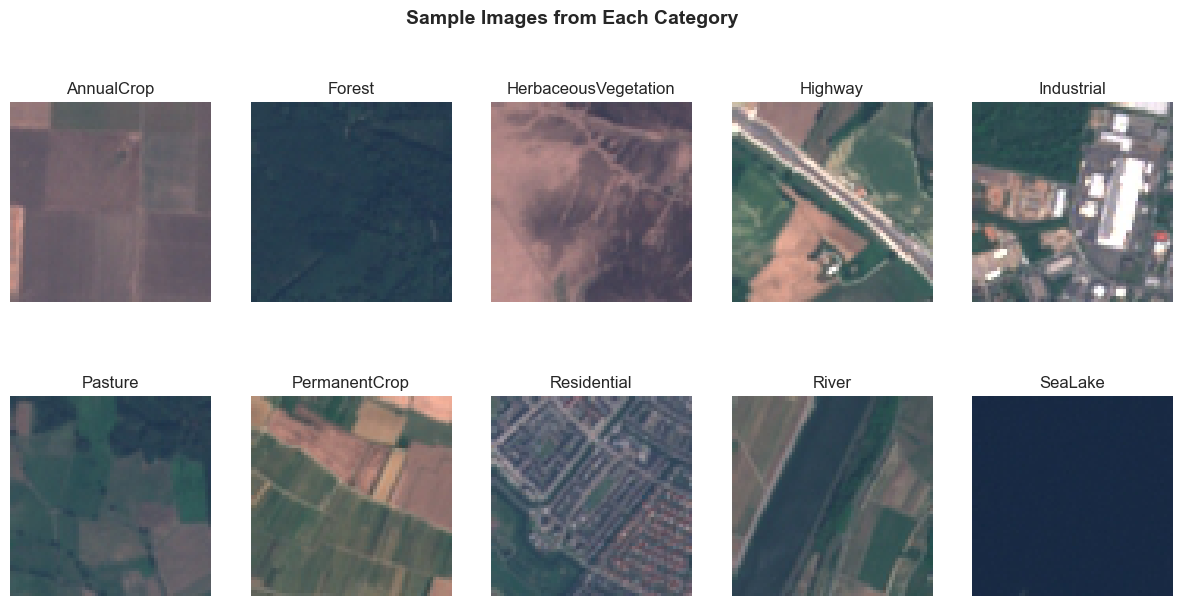

In [5]:
# Visualize sample images from each category
plt.figure(figsize=(15, 7))
for i, category in enumerate(categories):
    category_path = os.path.join(dataset_path, category)
    sample_image = os.listdir(category_path)[0]
    img = Image.open(os.path.join(category_path, sample_image))
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(category)
    plt.axis('off')
plt.suptitle('Sample Images from Each Category', fontsize=14, fontweight='bold')
plt.show()

In [87]:
# List all land type categories
categories = os.listdir(dataset_path)

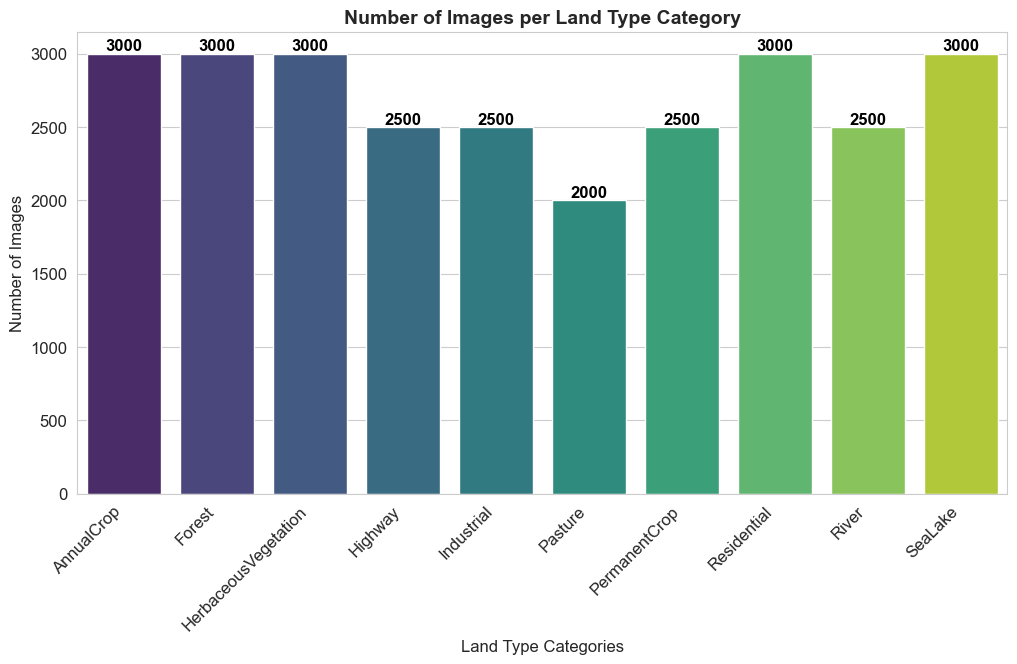

In [4]:
# Count the number of images per category
image_count = {}
for category in categories:
    category_path = os.path.join(dataset_path, category)
    image_count[category] = len(os.listdir(category_path))

# Set Seaborn style
sns.set_style("whitegrid")

# Create the bar plot (fix: assign `x` to `hue` and disable legend)
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=list(image_count.keys()), y=list(image_count.values()), hue=list(image_count.keys()), palette="viridis", legend=False)

# Add exact counts on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',  
                (p.get_x() + p.get_width() / 2., p.get_height()),  
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

# Improve readability
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.title('Number of Images per Land Type Category', fontsize=14, fontweight='bold')
plt.xlabel('Land Type Categories', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)

# Show the plot
plt.show()

In [6]:
# Check for missing data or corrupted images
def check_images(dataset_path):
    corrupted = []
    for category in categories:
        category_path = os.path.join(dataset_path, category)
        for img_name in os.listdir(category_path):
            try:
                img = Image.open(os.path.join(category_path, img_name))
                img.verify()
            except Exception as e:
                corrupted.append((category, img_name))
    return corrupted

In [7]:
corrupted_images = check_images(dataset_path)
print(f"Number of corrupted images: {len(corrupted_images)}")
if corrupted_images:
    print("Corrupted images:", corrupted_images)

Number of corrupted images: 0


In [8]:
# Analyze image sizes
image_shapes = []

# Iterate over all categories
for cls in categories:
    class_path = os.path.join(dataset_path, cls)
    images = os.listdir(class_path)
    
    # Iterate over all images in the category
    for img_name in images:
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        
        if img is not None:  # Avoid errors due to unreadable images
            image_shapes.append(img.shape)

# Count the occurrences of each shape
print("Image Dimensions (All Images):", Counter(image_shapes))


# # Iterate through all images to check their dimensions
# for class_folder in os.listdir(dataset_path):
#     class_path = os.path.join(dataset_path, class_folder)
#     if os.path.isdir(class_path):
#         for img_name in os.listdir(class_path):
#             img_path = os.path.join(class_path, img_name)
#             img = Image.open(img_path)
#             image_shapes.append(img.size)

# # Check unique image sizes
# unique_sizes = set(all_shapes)
# print("Unique image sizes:", unique_sizes)

Image Dimensions (All Images): Counter({(64, 64, 3): 27000})


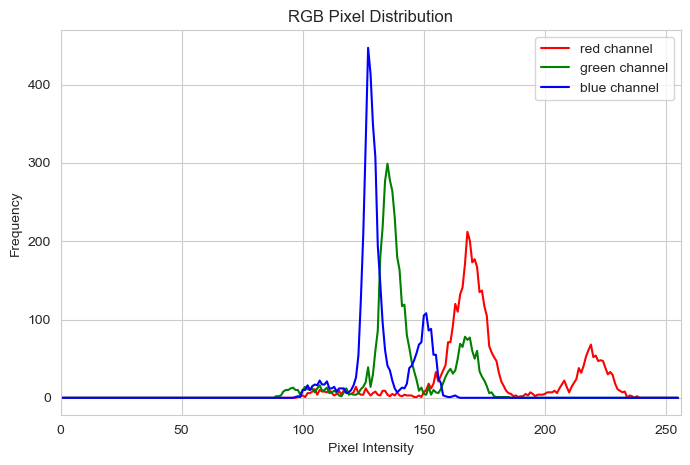

In [9]:
# Visualize RGB histograms for sample image

import random

def plot_pixel_distribution(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    colors = ("red", "green", "blue")
    plt.figure(figsize=(8, 5))

    for i, color in enumerate(colors):
        hist = cv2.calcHist([img], [i], None, [256], [0, 256])
        plt.plot(hist, color=color, label=f"{color} channel")
        plt.xlim([0, 256])

    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title("RGB Pixel Distribution")
    plt.show()

# Test with one random image
random_img_path = os.path.join(dataset_path, "AnnualCrop", random.choice(os.listdir(os.path.join(dataset_path, "AnnualCrop"))))
plot_pixel_distribution(random_img_path)

#### Key Observations:
- The **blue** channel has a strong peak around 100, meaning the image has a **dominant blue tone**.
- The **green** channel has a peak around 90-110, suggesting a **significant presence of green shades**.
- The **red** channel has multiple smaller peaks spread across 50-150, indicating that **red** tones are **distributed more variably**.
- There are almost no pixels beyond **200** intensity, meaning the image does not have pure **white** or very bright areas.

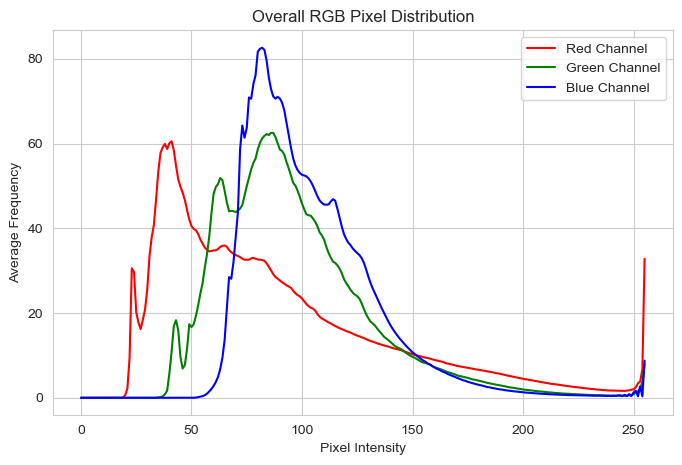

In [10]:
# RGB Pixel Distribution Graph
def compute_pixel_distribution(dataset_path, categories):
    total_hist_r = np.zeros(256)
    total_hist_g = np.zeros(256)
    total_hist_b = np.zeros(256)
    
    total_images = 0

    for category in categories:
        class_folder = os.path.join(dataset_path, category)
        image_files = os.listdir(class_folder)
        
        for img_name in image_files:
            img_path = os.path.join(class_folder, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            hist_r = cv2.calcHist([img], [0], None, [256], [0, 256]).flatten()
            hist_g = cv2.calcHist([img], [1], None, [256], [0, 256]).flatten()
            hist_b = cv2.calcHist([img], [2], None, [256], [0, 256]).flatten()
            
            total_hist_r += hist_r
            total_hist_g += hist_g
            total_hist_b += hist_b
            total_images += 1

    # Normalize histograms
    total_hist_r /= total_images
    total_hist_g /= total_images
    total_hist_b /= total_images

    # Plot results
    plt.figure(figsize=(8, 5))
    plt.plot(total_hist_r, color="red", label="Red Channel")
    plt.plot(total_hist_g, color="green", label="Green Channel")
    plt.plot(total_hist_b, color="blue", label="Blue Channel")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Average Frequency")
    plt.legend()
    plt.title("Overall RGB Pixel Distribution")
    plt.show()

# Compute and plot pixel intensity distribution for all images
compute_pixel_distribution(dataset_path, categories)

### 📊 Understanding the RGB Pixel Distribution Graph

#### **Graph Explanation**
- **X-axis**: Represents **pixel intensity values** (0-255), where:
  - `0` → **Black** (lowest intensity)
  - `255` → **White** (highest intensity)
- **Y-axis**: Represents the **average frequency** of each intensity across all images.
- **Curves Represent Different Channels:**
  - 🔴 **Red Channel**
  - 🟢 **Green Channel**
  - 🔵 **Blue Channel**

#### **📌 Key Insights from the Graph**
1. **Blue Dominance Around 80-100 Intensity**  
   - The blue curve has the highest peak around **80-100**.
   - This suggests that many images in the dataset contain **blueish tones** (e.g., water bodies, sky, or shadows).

2. **Green and Red Are More Spread Out**  
   - The **green curve** peaks between **50-100**, indicating the presence of **vegetation or natural elements**.
   - The **red curve** is more distributed, with peaks around **40-60**, suggesting the presence of **soil, buildings, or reddish tones**.

3. **Low Intensities (Shadows/Dark Areas)**  
   - The left side of the graph (0-50) shows noticeable activity in **red and green**, meaning some images have **dark or shadowed areas**.

4. **High Intensities (Bright Areas)**  
   - The right side of the graph (200-255) has lower values, meaning fewer **very bright areas** exist in the dataset.

## Step 3: Data Preprocessing:

In [4]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [70]:
# Resize, normalize, and convert to RGB
def load_and_preprocess_images(path, size=(64, 64)):
    data, labels = [], []
    for category in categories:
        category_path = os.path.join(path, category)
        for img_name in os.listdir(category_path):
            img = cv2.imread(os.path.join(category_path, img_name))
            img = cv2.resize(img, size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            img = img / 255.0  # Normalize to [0,1]
            data.append(img)
            labels.append(category)
    return np.array(data, dtype="float32"), np.array(labels)

In [71]:
# Load data
data, labels = load_and_preprocess_images(dataset_path)

In [72]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [73]:
# Encode labels into integers
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)  # Convert category names to integer labels

In [74]:
# Convert to one-hot encoding
labels_categorical = to_categorical(labels_encoded)

In [75]:
# Split dataset into train (70%), validation (20%), and test (10%)
X_train, X_temp, y_train, y_temp = train_test_split(data, labels_categorical, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)

In [76]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
)

# datagen = ImageDataGenerator(
#     rotation_range=25,    # Slightly increased, but not too much
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     shear_range=0.1  # Just a little shear (not too aggressive)
# )

In [77]:
val_test_datagen = ImageDataGenerator()  # No rescale!

# Final datasets
train_generator = datagen.flow(X_train, y_train, batch_size=32, shuffle=True)
val_generator = val_test_datagen.flow(X_val, y_val, batch_size=32, shuffle=False)
test_generator = val_test_datagen.flow(X_test, y_test, batch_size=32, shuffle=False)

#### Visualizing Augmented Images
Since we've applied transformations, it's essential to visualize the modified images to ensure they're applied correctly.

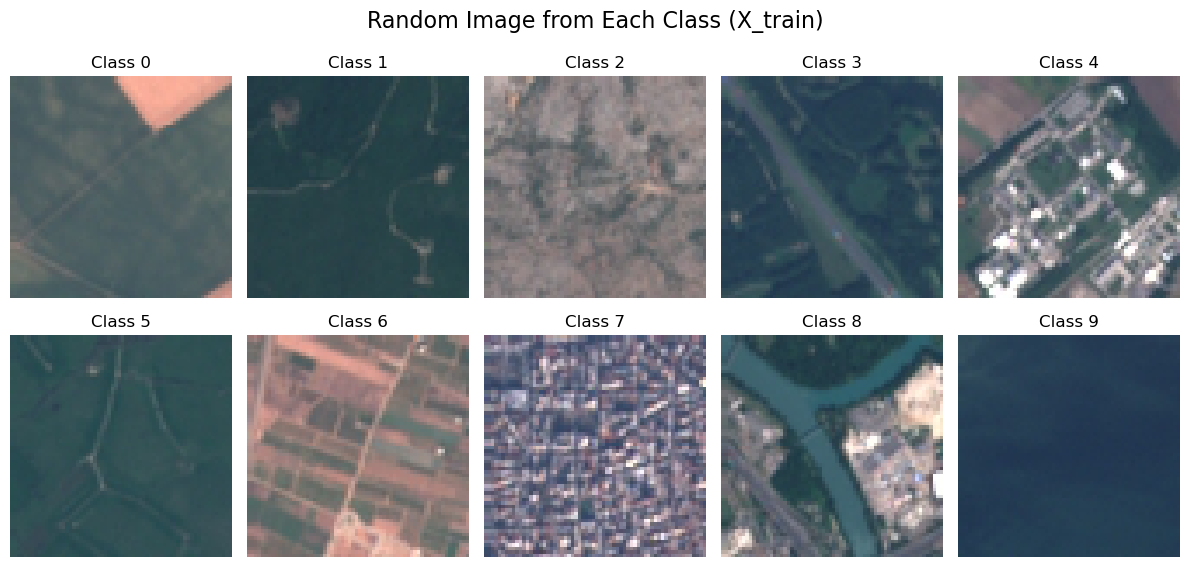

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Get the unique class indices
num_classes = y_train.shape[1]  # Number of classes
class_indices = np.argmax(y_train, axis=1)  # Convert one-hot to class labels

# Create a figure for visualization
plt.figure(figsize=(12, 6))

for class_id in range(num_classes):
    # Get all indices of images belonging to this class
    indices = np.where(class_indices == class_id)[0]
    
    # Pick a random index
    random_idx = random.choice(indices)
    
    # Get the image
    img = X_train[random_idx]
    
    # Plot the image
    plt.subplot(2, (num_classes + 1) // 2, class_id + 1)
    plt.imshow(img)
    plt.title(f"Class {class_id}")
    plt.axis('off')

plt.suptitle("Random Image from Each Class (X_train)", fontsize=16)
plt.tight_layout()
plt.show()


#### Class Distribution Visualization (After Preprocessing)

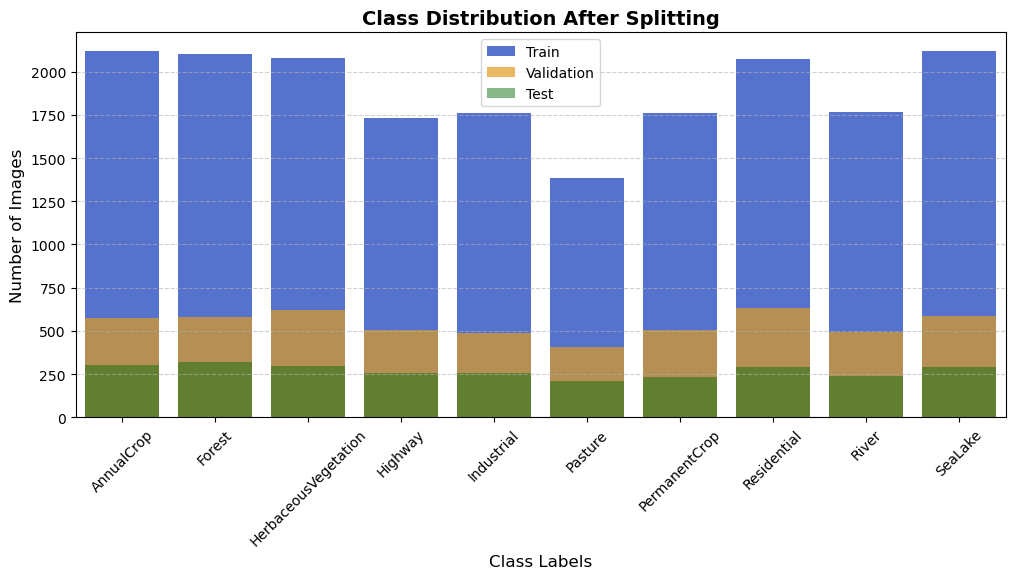

In [17]:
# Convert one-hot encoded labels to class indices
train_labels = np.argmax(y_train, axis=1)
val_labels = np.argmax(y_val, axis=1)
test_labels = np.argmax(y_test, axis=1)

# Count the number of occurrences per class
train_counts = Counter(train_labels)
val_counts = Counter(val_labels)
test_counts = Counter(test_labels)

# Get class names
class_names = label_encoder.classes_  # Assuming label_encoder was used for encoding

# Convert data to list format for seaborn
class_labels = list(class_names)
train_values = [train_counts[i] for i in range(len(class_names))]
val_values = [val_counts[i] for i in range(len(class_names))]
test_values = [test_counts[i] for i in range(len(class_names))]

# Plot class distribution for train, val, and test
plt.figure(figsize=(12, 5))
sns.barplot(x=class_labels, y=train_values, color="royalblue", label="Train")
sns.barplot(x=class_labels, y=val_values, color="orange", label="Validation", alpha=0.7)
sns.barplot(x=class_labels, y=test_values, color="green", label="Test", alpha=0.5)

# Add labels & title
plt.xlabel("Class Labels", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.title("Class Distribution After Splitting", fontsize=14, fontweight="bold")

plt.xticks(rotation=45, fontsize=10)  # Rotate labels for better visibility
plt.yticks(fontsize=10)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.show()

In [18]:
# Check total samples
print(f"Total Data: {len(data)}")
print(f"Train Set: {len(X_train)}")
print(f"Validation Set: {len(X_val)}")
print(f"Test Set: {len(X_test)}")

Total Data: 27000
Train Set: 18900
Validation Set: 5400
Test Set: 2700


## PCA & t-SNE for Feature Visualization
Dimensionality reduction techniques like t-SNE or PCA can visualize image clusters.

#### Benefits of Using PCA & t-SNE in EDA
- **Feature Understanding**:
  - Helps inspect how well the dataset is structured.
  - Identifies similarities and differences between images.
- **Class Distribution & Clustering**:
  - Shows whether different classes form distinct clusters.
  - Detects overlapping or misclassified classes.
- **Detecting Anomalies**:
  - Helps spot outliers in the dataset.
  - Unusual points may indicate data quality issues.
- **Model Selection Insight**:
  - If classes are well-separated, a simple classifier like Logistic Regression might work.
  - If classes overlap, a deep learning model may be needed.

In [14]:
# Create DataLoaders
# DataLoaders help in loading batches efficiently during training:
from torch.utils.data import DataLoader

batch_size = 64

train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(X_val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=False)

In [22]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [23]:
# Function to extract image features from the dataset
def extract_features(dataloader):
    features = []
    labels = []
    
    for images, lbls in dataloader:
        images = images.view(images.size(0), -1)  # Flatten images
        features.append(images.numpy())
        labels.extend(lbls.numpy())
    
    return np.vstack(features), np.array(labels)

In [24]:
# Extract features from training set
features, labels = extract_features(train_loader)

In [25]:
# Apply PCA (reduce to 2 components for visualization)
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features)

In [26]:
# Apply t-SNE (reduce to 2 components for visualization)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_features = tsne.fit_transform(features)

Text(0, 0.5, 'Principal Component 2')

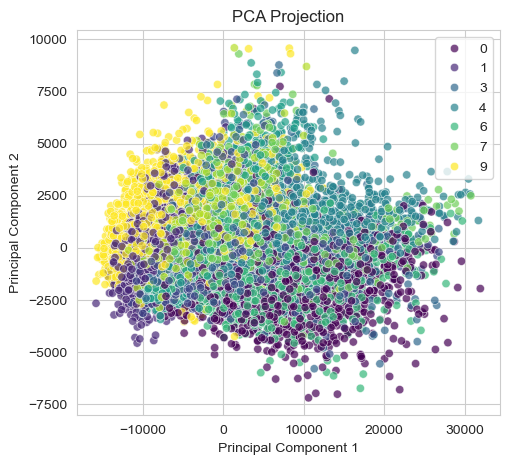

In [27]:
# Plot PCA
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=labels, palette="viridis", alpha=0.7)
plt.title("PCA Projection")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

Text(0, 0.5, 't-SNE Component 2')

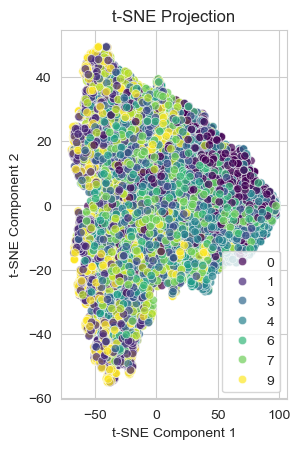

In [28]:
# Plot t-SNE
plt.subplot(1, 2, 2)
sns.scatterplot(x=tsne_features[:, 0], y=tsne_features[:, 1], hue=labels, palette="viridis", alpha=0.7)
plt.title("t-SNE Projection")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

#### Conclusion:
- High overlap in PCA & t-SNE means the dataset does not have well-separated clusters **(not linearly separable)**.
  - This suggests that images from different classes look somewhat similar in feature space.
  - Simple classifiers like logistic regression or linear SVM may struggle.
- t-SNE improves local clustering slightly, but classes are still mixed.
  - This tells us that even with a non-linear method, the data does not have naturally distinct groups.

#### We might need better feature extraction (e.g., CNN embeddings) to extract better features before classification to classify the data well.

# Step 4: Modelling:

## Overview of CNN, VGG, and ResNet

### Convolutional Neural Networks (CNN)
#### 🔹 Definition
A **Convolutional Neural Network (CNN)** is a deep learning model designed for image processing tasks. It automatically extracts features from images using convolutional layers.

#### 🔹 Key Components
- **Convolutional Layers**: Detect patterns using filters (kernels)
- **Pooling Layers**: Reduce dimensions while preserving features
- **Fully Connected Layers**: Classify the extracted features
- **Activation Functions**: Typically ReLU for non-linearity

#### 🔹 Advantages
✅ Captures spatial relationships in images  
✅ Reduces number of parameters compared to traditional networks  
✅ Suitable for image classification, object detection, and segmentation  
✅ no manual feature extraction & engineering needed.  


### VGG (Visual Geometry Group)
#### 🔹 Definition
**VGG** is a deep CNN architecture proposed by Oxford’s Visual Geometry Group. It uses small (3×3) filters and deep architectures for improved performance.

#### 🔹 Key Features
- **VGG16** and **VGG19** are common variants (16 or 19 layers deep)
- Uses **only 3×3 convolutional filters**
- **Pre-trained models** available (e.g., on ImageNet)
- Fully connected layers at the end for classification

#### 🔹 Advantages
✅ Simple architecture, easy to implement  
✅ Works well for image classification  
✅ Transfer learning available with pre-trained models  

#### 🔹 Disadvantages
❌ High number of parameters (~138M in VGG16)  
❌ Computationally expensive and slow training  

---

### ResNet (Residual Networks)
#### 🔹 Definition
**ResNet** is a deep learning architecture that introduced *Residual Learning* to solve the vanishing gradient problem in deep networks.

#### 🔹 Key Features
- Uses **skip connections** (shortcut paths) to enable deeper networks
- Popular variants: **ResNet-18, ResNet-34, ResNet-50, ResNet-101**
- Avoids performance degradation in very deep models
- Works well for image recognition tasks

#### 🔹 Advantages
✅ Enables very deep networks without vanishing gradients  
✅ Improves training stability and accuracy  
✅ State-of-the-art performance in image classification  

#### 🔹 Disadvantages
❌ More complex than traditional CNNs  
❌ Requires more computational power  

---

### 🔥 Summary Table
| Model | Depth | Key Feature | Pros | Cons |
|-------|-------|------------|------|------|
| **CNN** | Varies | Feature extraction & classification | Efficient for images | Can struggle with very deep networks |
| **VGG** | 16 or 19 | Deep CNN with 3×3 filters | Simple & effective | High number of parameters |
| **ResNet** | 18, 34, 50, 101+ | Skip connections | Solves vanishing gradient problem | Complex architecture |

📌 **Best Choice?** Depends on the task:  
- **Basic image classification?** CNN or VGG  
- **State-of-the-art accuracy?** ResNet  
- **Transfer learning?** VGG or ResNet  

🚀 Choose the right model based on accuracy, computational resources, and task requirements!

In [79]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

## **CNN** Model

### Model Building

In [80]:
cnn_model = models.Sequential([
    layers.Input(shape=(64, 64, 3)),  # Explicit input layer
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),  # Added one more layer
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),  # Increased capacity
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dense(len(categories), activation='softmax')
])

In [81]:
# Compile model
cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [82]:
# Learning rate scheduling
lr_schedule = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [83]:
# Add EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

### Model Training

In [84]:
# Train model
history = cnn_model.fit(train_generator,
                        epochs=60,  # Allow training longer, early stopping prevents overfitting
                        validation_data=val_generator,
                        callbacks=[lr_schedule, early_stopping])

Epoch 1/60


C:\Users\Mostafa\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


591/591 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4607 - loss: 2.0064 - val_accuracy: 0.4461 - val_loss: 1.5893 - learning_rate: 0.0010
Epoch 2/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 28s 47ms/step - accuracy: 0.6603 - loss: 0.9665 - val_accuracy: 0.4696 - val_loss: 2.2049 - learning_rate: 0.0010
Epoch 3/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 28s 47ms/step - accuracy: 0.7031 - loss: 0.8424 - val_accuracy: 0.5152 - val_loss: 1.8414 - learning_rate: 0.0010
Epoch 4/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 28s 48ms/step - accuracy: 0.7505 - loss: 0.7230 - val_accuracy: 0.6719 - val_loss: 0.9476 - learning_rate: 0.0010
Epoch 5/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 30s 50ms/step - accuracy: 0.7820 - loss: 0.6437 - val_accuracy: 0.5356 - val_loss: 1.3799 - learning_rate: 0.0010
Epoch 6/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 31s 52ms/step - accuracy: 0.8169 - loss: 0.5464 - val_accuracy: 0.6931 - val_loss: 0.9657 - learning_rate: 0.0010
Epoch 7/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 31s 52ms/step - accuracy: 0.8330 - loss: 0.5081

In [88]:
# Summary of the Updated Model
cnn_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)                   │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 512)                 │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,863,776 (30.00 MB)

 Trainable params: 2,620,938 (10.00 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 5,241,878 (20.00 MB)

### Model Evaluation

In [89]:
# Function to Evaluate Keras Model
def evaluate_model(model, X_test, y_test, class_names):
    # Get model predictions
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels
    y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class indices

    # Compute accuracy
    accuracy = accuracy_score(y_true, y_pred) * 100  # Convert to percentage

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    # Print classification report
    print(classification_report(y_true, y_pred, target_names=class_names))
    print(f"Final Accuracy: {accuracy:.2f}%")  # Print final accuracy

85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


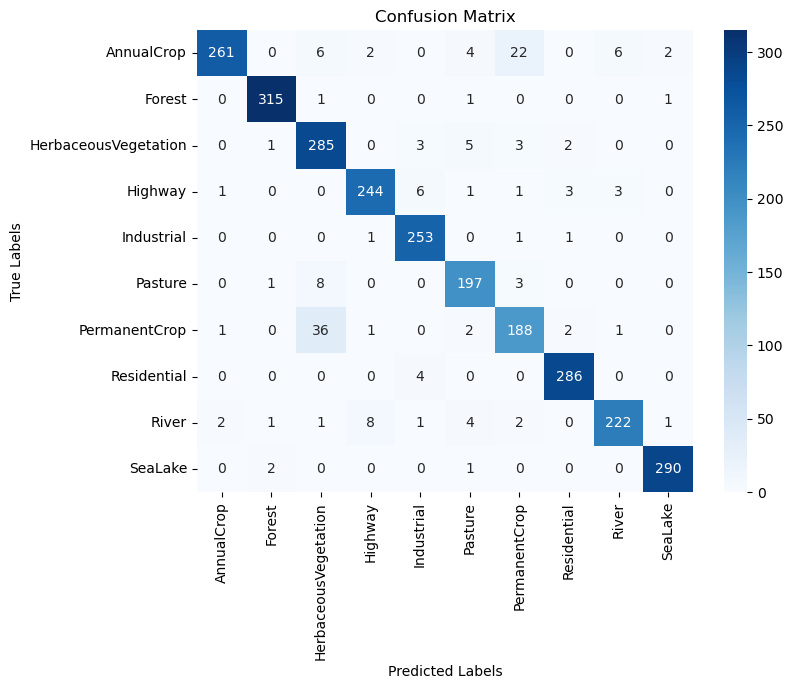

                      precision    recall  f1-score   support

          AnnualCrop       0.98      0.86      0.92       303
              Forest       0.98      0.99      0.99       318
HerbaceousVegetation       0.85      0.95      0.90       299
             Highway       0.95      0.94      0.95       259
          Industrial       0.95      0.99      0.97       256
             Pasture       0.92      0.94      0.93       209
       PermanentCrop       0.85      0.81      0.83       231
         Residential       0.97      0.99      0.98       290
               River       0.96      0.92      0.94       242
             SeaLake       0.99      0.99      0.99       293

            accuracy                           0.94      2700
           macro avg       0.94      0.94      0.94      2700
        weighted avg       0.94      0.94      0.94      2700

Final Accuracy: 94.11%


In [90]:
# Call the function
evaluate_model(cnn_model, X_test, y_test, class_names=categories)

In [147]:
cnn_model.save('cnn_model.h5')

### Hyperparameter Tunning

In [102]:
import keras_tuner as kt

In [103]:
# Define the hyperparameter tuning function
def build_model(hp):
    model = models.Sequential([
        layers.Input(shape=(64, 64, 3)),  # Input layer

        # First Conv Block
        layers.Conv2D(hp.Choice('filters_1', [32, 64]), (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Second Conv Block
        layers.Conv2D(hp.Choice('filters_2', [64, 128]), (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Third Conv Block
        layers.Conv2D(hp.Choice('filters_3', [128, 256]), (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),  # Flatten before fully connected layers

        # Fully Connected Layers
        layers.Dense(hp.Choice('dense_units', [256, 512]), activation='relu'),
        layers.Dropout(hp.Float('dropout_rate', 0.3, 0.6, step=0.1)),  # Dropout for regularization
        layers.Dense(len(categories), activation='softmax')  # Output layer
    ])
    
    # Compile model with a tunable learning rate
    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [104]:
# Initialize Keras Tuner with Random Search
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',  # Optimize for validation accuracy
    max_trials=10,  # Number of different hyperparameter combinations to try
    executions_per_trial=2,  # Run each model twice for better evaluation
    directory='D:/tuner_dir',  # Save results in this directory
    project_name='cnn_tuning'
)

In [105]:
# Define EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',  # Stop if validation loss stops improving
    patience=5,  # Allow 5 epochs of no improvement
    restore_best_weights=True
)

In [106]:
# Run the hyperparameter search
tuner.search(
    train_generator, 
    validation_data=val_generator, 
    epochs=20,  # Max number of epochs (early stopping can stop earlier)
    callbacks=[early_stopping]  # Include EarlyStopping
)

Trial 10 Complete [00h 17m 48s]
val_accuracy: 0.8522222340106964

Best val_accuracy So Far: 0.9024074077606201
Total elapsed time: 03h 25m 20s


In [108]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print best hyperparameters
print(f"""
Best Hyperparameters:
- Filters_1: {best_hps.get('filters_1')}
- Filters_2: {best_hps.get('filters_2')}
- Filters_3: {best_hps.get('filters_3')}
- Dense Units: {best_hps.get('dense_units')}
- Dropout Rate: {best_hps.get('dropout_rate')}
- Learning Rate: {best_hps.get('learning_rate')}
""")


Best Hyperparameters:
- Filters_1: 32
- Filters_2: 128
- Filters_3: 128
- Dense Units: 512
- Dropout Rate: 0.4
- Learning Rate: 0.001



In [109]:
# Build the best model with optimal hyperparameters
best_model = tuner.hypermodel.build(best_hps)

In [110]:
# Train the best model with early stopping
history = best_model.fit(
    train_generator,
    epochs=60,  # Train longer now that we have optimal hyperparameters
    validation_data=val_generator,
    callbacks=[early_stopping]
)

Epoch 1/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 45s 73ms/step - accuracy: 0.4893 - loss: 2.1136 - val_accuracy: 0.5472 - val_loss: 1.4898
Epoch 2/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 42s 71ms/step - accuracy: 0.6295 - loss: 1.0579 - val_accuracy: 0.5337 - val_loss: 1.4777
Epoch 3/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 42s 70ms/step - accuracy: 0.6632 - loss: 0.9524 - val_accuracy: 0.3959 - val_loss: 3.1621
Epoch 4/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 41s 70ms/step - accuracy: 0.7009 - loss: 0.8592 - val_accuracy: 0.6787 - val_loss: 1.0411
Epoch 5/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 42s 70ms/step - accuracy: 0.7198 - loss: 0.8052 - val_accuracy: 0.5446 - val_loss: 2.3591
Epoch 6/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 42s 70ms/step - accuracy: 0.7466 - loss: 0.7473 - val_accuracy: 0.7502 - val_loss: 0.8664
Epoch 7/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 42s 71ms/step - accuracy: 0.7691 - loss: 0.6721 - val_accuracy: 0.6552 - val_loss: 1.3304
Epoch 8/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 42s 71ms/step - accuracy: 0.7936 - loss: 0.6146 - 

85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


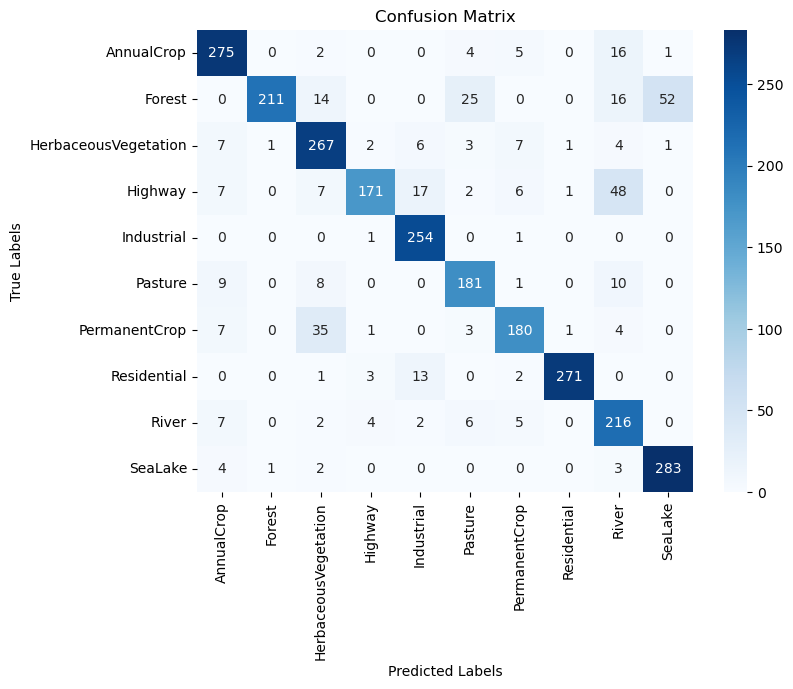

                      precision    recall  f1-score   support

          AnnualCrop       0.87      0.91      0.89       303
              Forest       0.99      0.66      0.79       318
HerbaceousVegetation       0.79      0.89      0.84       299
             Highway       0.94      0.66      0.78       259
          Industrial       0.87      0.99      0.93       256
             Pasture       0.81      0.87      0.84       209
       PermanentCrop       0.87      0.78      0.82       231
         Residential       0.99      0.93      0.96       290
               River       0.68      0.89      0.77       242
             SeaLake       0.84      0.97      0.90       293

            accuracy                           0.86      2700
           macro avg       0.86      0.86      0.85      2700
        weighted avg       0.87      0.86      0.85      2700

Final Accuracy: 85.52%


In [111]:
evaluate_model(best_model, X_test, y_test, class_names=categories)

In [112]:
# Save the best model
best_model.save('best_cnn_model.h5')

## Another **CNN** Model

### Model Building

In [113]:
cnn1_model = models.Sequential([
    layers.Input(shape=(64, 64, 3)),  # Explicit input layer
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),  
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),  # One dense layer
    layers.Dropout(0.5),
    layers.Dense(len(categories), activation='softmax')  # Output layer
])

# Compile model
cnn1_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### Model Training

In [114]:
# Learning rate scheduling
lr_schedule = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Add EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
# Train model
h1istory = cnn1_model.fit(
    train_generator,
    epochs=60,  # Allow training longer, early stopping prevents overfitting
    validation_data=val_generator,
    callbacks=[lr_schedule, early_stopping])

Epoch 1/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.3348 - loss: 1.7121 - val_accuracy: 0.5683 - val_loss: 1.1501 - learning_rate: 0.0010
Epoch 2/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.6183 - loss: 1.0628 - val_accuracy: 0.6435 - val_loss: 0.9387 - learning_rate: 0.0010
Epoch 3/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - accuracy: 0.6679 - loss: 0.9160 - val_accuracy: 0.7544 - val_loss: 0.6871 - learning_rate: 0.0010
Epoch 4/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - accuracy: 0.7071 - loss: 0.8222 - val_accuracy: 0.7609 - val_loss: 0.6589 - learning_rate: 0.0010
Epoch 5/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - accuracy: 0.7477 - loss: 0.7110 - val_accuracy: 0.7878 - val_loss: 0.6117 - learning_rate: 0.0010
Epoch 6/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - accuracy: 0.7801 - loss: 0.6245 - val_accuracy: 0.7878 - val_loss: 0.6215 - learning_rate: 0.0010
Epoch 7/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - accuracy: 0.7991 - l

### Model Evaluation

85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


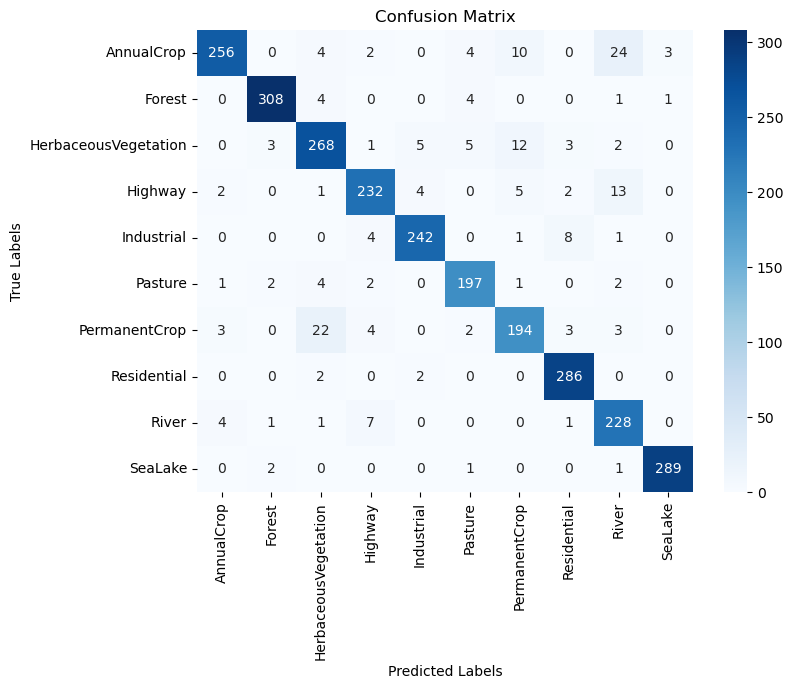

                      precision    recall  f1-score   support

          AnnualCrop       0.96      0.84      0.90       303
              Forest       0.97      0.97      0.97       318
HerbaceousVegetation       0.88      0.90      0.89       299
             Highway       0.92      0.90      0.91       259
          Industrial       0.96      0.95      0.95       256
             Pasture       0.92      0.94      0.93       209
       PermanentCrop       0.87      0.84      0.85       231
         Residential       0.94      0.99      0.96       290
               River       0.83      0.94      0.88       242
             SeaLake       0.99      0.99      0.99       293

            accuracy                           0.93      2700
           macro avg       0.92      0.92      0.92      2700
        weighted avg       0.93      0.93      0.93      2700

Final Accuracy: 92.59%


In [115]:
evaluate_model(cnn1_model, X_test, y_test, class_names=categories)

In [150]:
cnn1_model.save('cnn1_model.h5')

### Hyperparameter Tunning

In [116]:
# Define model with tunable hyperparameters
def build1_model(hp):
    model = models.Sequential([
        layers.Input(shape=(64, 64, 3)),
        
        layers.Conv2D(hp.Choice('filters_1', [32, 64]), (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(hp.Choice('filters_2', [64, 128]), (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(hp.Choice('filters_3', [128, 256]), (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(hp.Choice('filters_4', [256, 512]), (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(hp.Choice('dense_units', [128, 256, 512]), activation='relu'),
        layers.Dropout(hp.Float('dropout_rate', 0.3, 0.6, step=0.1)),
        layers.Dense(len(categories), activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [117]:
# Create tuner
t1uner = kt.RandomSearch(
    build1_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='D:/tuner1_dir',
    project_name='cnn1_tuning'
)

# EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Stop if no improvement in 5 epochs
    restore_best_weights=True
)

# Run hyperparameter search with EarlyStopping
t1uner.search(
    train_generator,
    validation_data=val_generator,
    epochs=60,  # Set high, but EarlyStopping will stop early if needed
    callbacks=[early_stopping]
)

Trial 10 Complete [00h 13m 38s]
val_accuracy: 0.8088889122009277

Best val_accuracy So Far: 0.939259260892868
Total elapsed time: 03h 48m 36s


In [118]:
# Get best model
best1_hps = t1uner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: Filters_1={best1_hps.get('filters_1')}, "
      f"Filters_2={best1_hps.get('filters_2')}, Filters_3={best1_hps.get('filters_3')}, "
      f"Filters_4={best1_hps.get('filters_4')}, Dense={best1_hps.get('dense_units')}, "
      f"Dropout={best1_hps.get('dropout_rate')}, Learning Rate={best1_hps.get('learning_rate')}")

Best Hyperparameters: Filters_1=64, Filters_2=64, Filters_3=256, Filters_4=256, Dense=256, Dropout=0.4, Learning Rate=0.0005


In [119]:
# Build the best model with optimal hyperparameters
best1_model = t1uner.hypermodel.build(best1_hps)

In [120]:
# Train the best model with early stopping
h1istory = best1_model.fit(
    train_generator,
    epochs=60,  # Train longer now that we have optimal hyperparameters
    validation_data=val_generator,
    callbacks=[early_stopping]
)

Epoch 1/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 29s 48ms/step - accuracy: 0.3262 - loss: 1.7197 - val_accuracy: 0.6091 - val_loss: 1.0874
Epoch 2/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 28s 48ms/step - accuracy: 0.6158 - loss: 1.0714 - val_accuracy: 0.7170 - val_loss: 0.7851
Epoch 3/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 28s 48ms/step - accuracy: 0.6894 - loss: 0.8570 - val_accuracy: 0.7589 - val_loss: 0.6811
Epoch 4/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 28s 48ms/step - accuracy: 0.7189 - loss: 0.7826 - val_accuracy: 0.7802 - val_loss: 0.6242
Epoch 5/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 29s 48ms/step - accuracy: 0.7640 - loss: 0.6685 - val_accuracy: 0.7980 - val_loss: 0.5946
Epoch 6/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 28s 48ms/step - accuracy: 0.7823 - loss: 0.6425 - val_accuracy: 0.7839 - val_loss: 0.6576
Epoch 7/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 28s 47ms/step - accuracy: 0.7982 - loss: 0.5750 - val_accuracy: 0.8474 - val_loss: 0.4337
Epoch 8/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 28s 48ms/step - accuracy: 0.8284 - loss: 0.5046 - 

85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


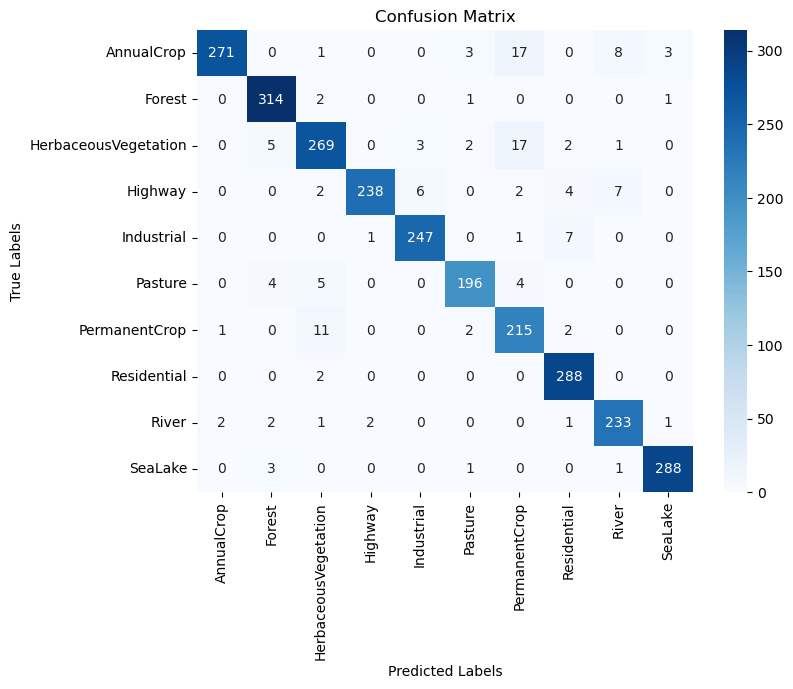

                      precision    recall  f1-score   support

          AnnualCrop       0.99      0.89      0.94       303
              Forest       0.96      0.99      0.97       318
HerbaceousVegetation       0.92      0.90      0.91       299
             Highway       0.99      0.92      0.95       259
          Industrial       0.96      0.96      0.96       256
             Pasture       0.96      0.94      0.95       209
       PermanentCrop       0.84      0.93      0.88       231
         Residential       0.95      0.99      0.97       290
               River       0.93      0.96      0.95       242
             SeaLake       0.98      0.98      0.98       293

            accuracy                           0.95      2700
           macro avg       0.95      0.95      0.95      2700
        weighted avg       0.95      0.95      0.95      2700

Final Accuracy: 94.78%


In [121]:
evaluate_model(best1_model, X_test, y_test, class_names=categories)

In [122]:
best1_model.save('best1_cnn_model.h5')

## Comparison between **First** CNN Model and **Second**

Explanation of Each Line in Your Pure CNN Model
This model follows a convolutional neural network (CNN) architecture designed for image classification.

🔹 Step-by-Step Breakdown
python
Copy
Edit
cnn_model = models.Sequential([
✅ Creates a Sequential Model → A linear stack of layers.

python
Copy
Edit
    layers.Input(shape=(64, 64, 3)),  # Explicit input layer
✅ Defines the Input Shape

(64, 64, 3): The model expects 64×64 images with 3 color channels (RGB).
Explicitly defining input shape ensures the model knows the expected dimensions.
🔹 First Convolutional Block
python
Copy
Edit
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
✅ Convolutional Layer (Conv2D)

32 filters (kernels) detect features (edges, textures).
(3,3): Kernel size (height × width) slides over the image.
activation='relu': Applies ReLU activation to remove negative values.
padding='same': Ensures output size remains the same after convolution.
✅ Batch Normalization

Normalizes activations to speed up training and improve stability.
✅ MaxPooling (2×2)

Reduces spatial size by half, keeping only the most important features.
Helps to reduce computation & prevent overfitting.
🔹 Second Convolutional Block
python
Copy
Edit
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
✅ Same structure as first block, but with 64 filters

Detects more complex patterns by increasing filter count.
🔹 Third Convolutional Block
python
Copy
Edit
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
✅ More filters (128) → Extracts deeper features.

Useful for detecting more abstract patterns in images.
🔹 Fourth Convolutional Block
python
Copy
Edit
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),  # Added one more layer
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
✅ Added another Conv layer with 256 filters

Extracts even more detailed & high-level features.
This is useful when working with complex images.
🔹 Fully Connected (Dense) Layers
python
Copy
Edit
    layers.Flatten(),
✅ Flattens the 2D feature maps into a 1D vector for the Dense layers.

python
Copy
Edit
    layers.Dense(512, activation='relu'),  # Increased capacity
✅ Fully Connected Layer with 512 Neurons

Learns abstract representations of the image.
High capacity (512 neurons) helps capture complex patterns.
python
Copy
Edit
    layers.Dropout(0.5),
✅ Dropout (0.5)

Randomly turns off 50% of neurons during training.
Helps prevent overfitting.
python
Copy
Edit
    layers.Dense(256, activation='relu'),
✅ Another Fully Connected Layer

Helps refine the learned features before final classification.
python
Copy
Edit
    layers.Dense(len(categories), activation='softmax')
✅ Output Layer

len(categories) → Number of output classes.
Softmax Activation → Converts logits into probabilities.
🛠 Difference Between This Model and the "Not Pure" Version?
💡 Your model is already a "pure" CNN! There is no fundamental difference between the two models you sent. Both use:
✅ Convolutional Layers (Conv2D)
✅ Batch Normalization
✅ Max Pooling
✅ Fully Connected Layers
✅ Dropout for Regularization

## **VGG** Model

### Model Building

In [123]:
from tensorflow.keras.applications import VGG16

# Load pre-trained VGG16 model (without top layers)
base_VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
base_VGG_model.trainable = False  # Freeze layers initially

# Custom classification head
model_VGG = models.Sequential([
    base_VGG_model,
    layers.GlobalAveragePooling2D(),  # Better than Flatten()
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')  # Adjust output units based on dataset
])

# Compile Model
model_VGG.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### Model Training

In [124]:
# Learning rate scheduling
lr_schedule = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Add EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
# Train model
historyVGG = model_VGG.fit(
    train_generator,
    epochs=60,  # Allow training longer, early stopping prevents overfitting
    validation_data=val_generator,
    callbacks=[lr_schedule, early_stopping])

Epoch 1/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 90s 151ms/step - accuracy: 0.4221 - loss: 1.7650 - val_accuracy: 0.7557 - val_loss: 0.8076 - learning_rate: 1.0000e-04
Epoch 2/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 90s 152ms/step - accuracy: 0.6658 - loss: 0.9634 - val_accuracy: 0.7861 - val_loss: 0.6726 - learning_rate: 1.0000e-04
Epoch 3/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 89s 150ms/step - accuracy: 0.7170 - loss: 0.8549 - val_accuracy: 0.8157 - val_loss: 0.5875 - learning_rate: 1.0000e-04
Epoch 4/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 91s 155ms/step - accuracy: 0.7374 - loss: 0.7750 - val_accuracy: 0.8152 - val_loss: 0.5704 - learning_rate: 1.0000e-04
Epoch 5/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 89s 150ms/step - accuracy: 0.7457 - loss: 0.7383 - val_accuracy: 0.8109 - val_loss: 0.5923 - learning_rate: 1.0000e-04
Epoch 6/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 89s 150ms/step - accuracy: 0.7578 - loss: 0.7057 - val_accuracy: 0.8220 - val_loss: 0.5470 - learning_rate: 1.0000e-04
Epoch 7/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 89s 15

### Model Evaluation

85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step


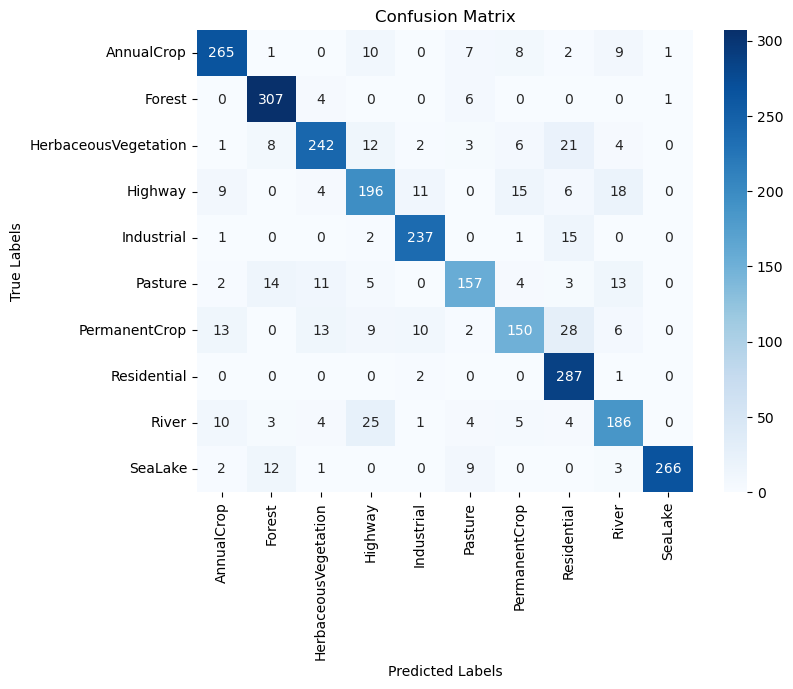

                      precision    recall  f1-score   support

          AnnualCrop       0.87      0.87      0.87       303
              Forest       0.89      0.97      0.93       318
HerbaceousVegetation       0.87      0.81      0.84       299
             Highway       0.76      0.76      0.76       259
          Industrial       0.90      0.93      0.91       256
             Pasture       0.84      0.75      0.79       209
       PermanentCrop       0.79      0.65      0.71       231
         Residential       0.78      0.99      0.88       290
               River       0.78      0.77      0.77       242
             SeaLake       0.99      0.91      0.95       293

            accuracy                           0.85      2700
           macro avg       0.85      0.84      0.84      2700
        weighted avg       0.85      0.85      0.85      2700

Final Accuracy: 84.93%


In [125]:
evaluate_model(model_VGG, X_test, y_test, class_names=categories)

### Hyperparameter Tunning

In [129]:
def build_vgg16_model(hp):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
    base_model.trainable = False  

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(hp.Choice('dense_units', [256, 512, 1024]), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(hp.Float('dropout_rate', 0.3, 0.6, step=0.1)),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

tuner_VGG = kt.RandomSearch(
    build_vgg16_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='D:/vgg16_tuner_dir',
    project_name='vgg16_tuning'
)

# EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Stop if no improvement in 5 epochs
    restore_best_weights=True
)

tuner_VGG.search(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stopping]
)

Trial 10 Complete [00h 47m 50s]
val_accuracy: 0.8450925946235657

Best val_accuracy So Far: 0.849907398223877
Total elapsed time: 08h 02m 08s


In [130]:
# Get best model
best_VGG_hps = tuner_VGG.get_best_hyperparameters(num_trials=1)[0]

In [131]:
# Build the best model with optimal hyperparameters
best_VGG_model = tuner_VGG.hypermodel.build(best_VGG_hps)

In [133]:
# Train the best model with early stopping
history_VGG = best_VGG_model.fit(
    train_generator,
    epochs=60,  # Train longer now that we have optimal hyperparameters
    validation_data=val_generator,
    callbacks=[early_stopping]
)

Epoch 1/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 84s 140ms/step - accuracy: 0.4266 - loss: 1.7334 - val_accuracy: 0.7619 - val_loss: 0.7839
Epoch 2/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 88s 149ms/step - accuracy: 0.6701 - loss: 0.9629 - val_accuracy: 0.7941 - val_loss: 0.6639
Epoch 3/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 89s 151ms/step - accuracy: 0.7141 - loss: 0.8463 - val_accuracy: 0.8031 - val_loss: 0.6240
Epoch 4/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 88s 149ms/step - accuracy: 0.7362 - loss: 0.7780 - val_accuracy: 0.8059 - val_loss: 0.6018
Epoch 5/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 89s 151ms/step - accuracy: 0.7518 - loss: 0.7406 - val_accuracy: 0.8202 - val_loss: 0.5660
Epoch 6/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 90s 151ms/step - accuracy: 0.7577 - loss: 0.7210 - val_accuracy: 0.8141 - val_loss: 0.5766
Epoch 7/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 89s 151ms/step - accuracy: 0.7688 - loss: 0.6912 - val_accuracy: 0.8270 - val_loss: 0.5399
Epoch 8/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 90s 153ms/step - accuracy: 0.7639 - loss: 0

85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step


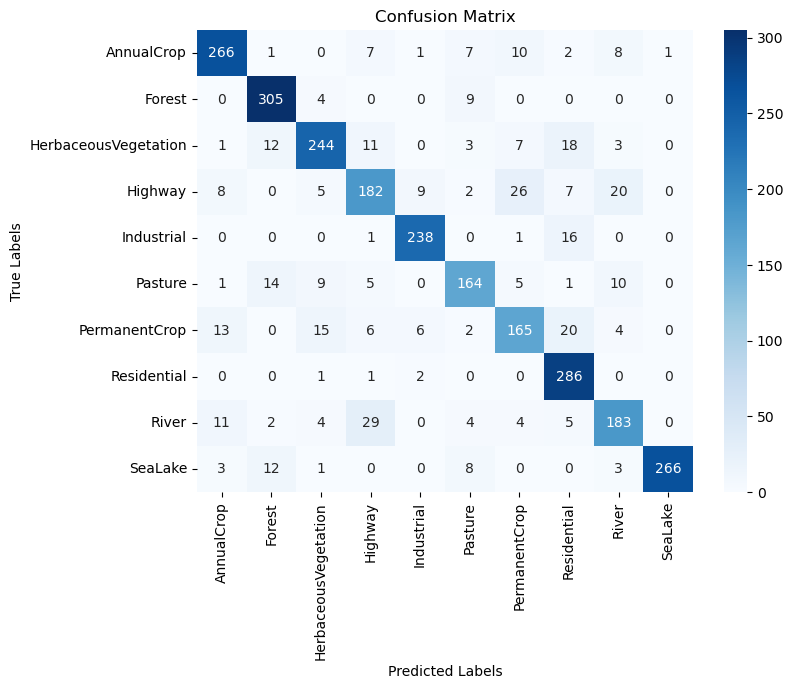

                      precision    recall  f1-score   support

          AnnualCrop       0.88      0.88      0.88       303
              Forest       0.88      0.96      0.92       318
HerbaceousVegetation       0.86      0.82      0.84       299
             Highway       0.75      0.70      0.73       259
          Industrial       0.93      0.93      0.93       256
             Pasture       0.82      0.78      0.80       209
       PermanentCrop       0.76      0.71      0.73       231
         Residential       0.81      0.99      0.89       290
               River       0.79      0.76      0.77       242
             SeaLake       1.00      0.91      0.95       293

            accuracy                           0.85      2700
           macro avg       0.85      0.84      0.84      2700
        weighted avg       0.85      0.85      0.85      2700

Final Accuracy: 85.15%


In [134]:
evaluate_model(best_VGG_model, X_test, y_test, class_names=categories)

In [135]:
best1_model.save('best_VGG_model.h5')

## **ResNet** Model

### Model Building

In [126]:
from tensorflow.keras.applications import ResNet50

# Load pre-trained ResNet50 model (without top layers)
base_resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
base_resnet_model.trainable = False  # Freeze layers initially

# Unfreeze last few layers for fine-tuning
for layer in base_resnet_model.layers[-5:]:
    layer.trainable = True

# Custom classification head
model_ResNet = models.Sequential([
    base_resnet_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')  # Adjust output units based on dataset
])

# Compile Model
model_ResNet.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### Model Training

In [127]:
# Learning rate scheduling
lr_schedule = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Add EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
# Train model
historyresnet = model_ResNet.fit(
    train_generator,
    epochs=60,  # Allow training longer, early stopping prevents overfitting
    validation_data=val_generator,
    callbacks=[lr_schedule, early_stopping])

Epoch 1/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 118s 194ms/step - accuracy: 0.3889 - loss: 1.8113 - val_accuracy: 0.3685 - val_loss: 2.1649 - learning_rate: 1.0000e-04
Epoch 2/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 112s 189ms/step - accuracy: 0.4981 - loss: 1.4796 - val_accuracy: 0.3644 - val_loss: 2.8970 - learning_rate: 1.0000e-04
Epoch 3/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 112s 190ms/step - accuracy: 0.5225 - loss: 1.3850 - val_accuracy: 0.3515 - val_loss: 2.0772 - learning_rate: 1.0000e-04
Epoch 4/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 116s 197ms/step - accuracy: 0.5354 - loss: 1.3339 - val_accuracy: 0.4094 - val_loss: 2.4059 - learning_rate: 1.0000e-04
Epoch 5/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 116s 197ms/step - accuracy: 0.5581 - loss: 1.2722 - val_accuracy: 0.3917 - val_loss: 2.0653 - learning_rate: 1.0000e-04
Epoch 6/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 115s 195ms/step - accuracy: 0.5606 - loss: 1.2549 - val_accuracy: 0.1876 - val_loss: 4.3534 - learning_rate: 1.0000e-04
Epoch 7/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 

### Model Evaluation

85/85 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step


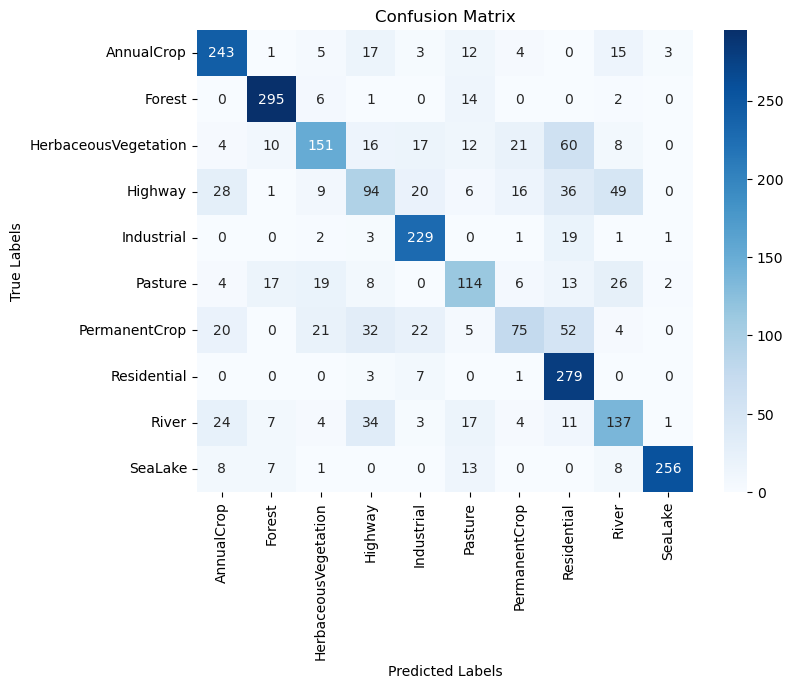

                      precision    recall  f1-score   support

          AnnualCrop       0.73      0.80      0.77       303
              Forest       0.87      0.93      0.90       318
HerbaceousVegetation       0.69      0.51      0.58       299
             Highway       0.45      0.36      0.40       259
          Industrial       0.76      0.89      0.82       256
             Pasture       0.59      0.55      0.57       209
       PermanentCrop       0.59      0.32      0.42       231
         Residential       0.59      0.96      0.73       290
               River       0.55      0.57      0.56       242
             SeaLake       0.97      0.87      0.92       293

            accuracy                           0.69      2700
           macro avg       0.68      0.68      0.67      2700
        weighted avg       0.69      0.69      0.68      2700

Final Accuracy: 69.37%


In [128]:
evaluate_model(model_ResNet, X_test, y_test, class_names=categories)

### Hyperparameter Tunning

In [137]:
def build_resnet50_model(hp):
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
    base_model.trainable = False  

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(hp.Choice('dense_units', [256, 512, 1024]), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(hp.Float('dropout_rate', 0.3, 0.6, step=0.1)),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

tuner_resnet = kt.RandomSearch(
    build_resnet50_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='D:/resnet50_tuner_dir',
    project_name='resnet50_tuning'
)

# EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Stop if no improvement in 5 epochs
    restore_best_weights=True
)

tuner_resnet.search(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stopping]
)

Trial 10 Complete [01h 10m 17s]
val_accuracy: 0.5507407486438751

Best val_accuracy So Far: 0.5555555522441864
Total elapsed time: 09h 43m 25s


In [140]:
# Get best model
best_resnet_hps = tuner_resnet.get_best_hyperparameters(num_trials=1)[0]

In [142]:
# Build the best model with optimal hyperparameters
best_resnet_model = tuner_resnet.hypermodel.build(best_resnet_hps)

In [143]:
# Train the best model with early stopping
history_resnet = best_resnet_model.fit(
    train_generator,
    epochs=60,  # Train longer now that we have optimal hyperparameters
    validation_data=val_generator,
    callbacks=[early_stopping]
)

Epoch 1/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 164s 272ms/step - accuracy: 0.3132 - loss: 1.9480 - val_accuracy: 0.1559 - val_loss: 2.4683
Epoch 2/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 163s 275ms/step - accuracy: 0.4159 - loss: 1.6135 - val_accuracy: 0.3259 - val_loss: 1.8869
Epoch 3/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 162s 274ms/step - accuracy: 0.4528 - loss: 1.5195 - val_accuracy: 0.3585 - val_loss: 1.7017
Epoch 4/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 163s 275ms/step - accuracy: 0.4837 - loss: 1.4448 - val_accuracy: 0.2506 - val_loss: 2.3973
Epoch 5/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 162s 275ms/step - accuracy: 0.4871 - loss: 1.4312 - val_accuracy: 0.5243 - val_loss: 1.4301
Epoch 6/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 162s 275ms/step - accuracy: 0.5087 - loss: 1.3816 - val_accuracy: 0.4565 - val_loss: 1.6721
Epoch 7/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 163s 277ms/step - accuracy: 0.5119 - loss: 1.3637 - val_accuracy: 0.4781 - val_loss: 1.3968
Epoch 8/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 157s 265ms/step - accuracy: 0.5212 -

85/85 ━━━━━━━━━━━━━━━━━━━━ 18s 202ms/step


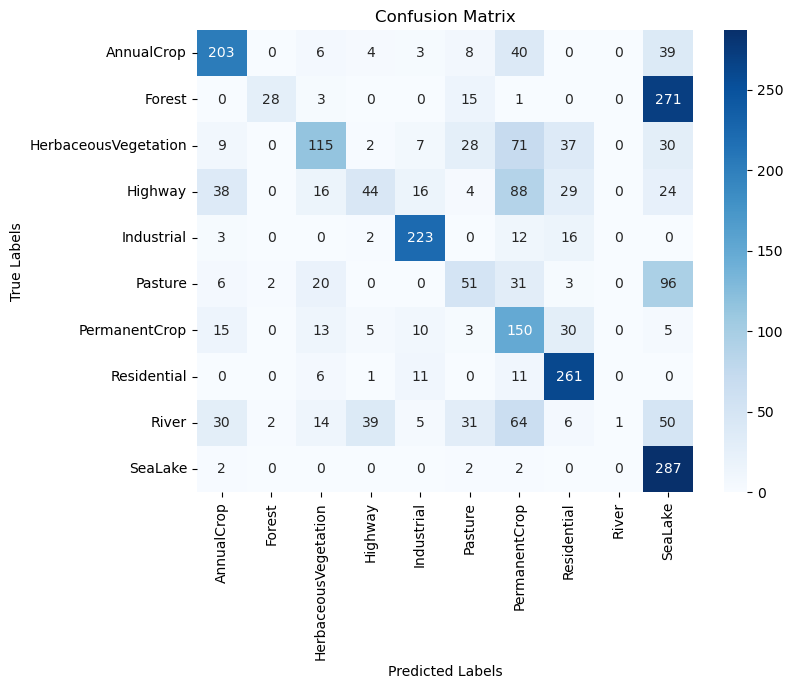

                      precision    recall  f1-score   support

          AnnualCrop       0.66      0.67      0.67       303
              Forest       0.88      0.09      0.16       318
HerbaceousVegetation       0.60      0.38      0.47       299
             Highway       0.45      0.17      0.25       259
          Industrial       0.81      0.87      0.84       256
             Pasture       0.36      0.24      0.29       209
       PermanentCrop       0.32      0.65      0.43       231
         Residential       0.68      0.90      0.78       290
               River       1.00      0.00      0.01       242
             SeaLake       0.36      0.98      0.52       293

            accuracy                           0.50      2700
           macro avg       0.61      0.50      0.44      2700
        weighted avg       0.62      0.50      0.45      2700

Final Accuracy: 50.48%


In [144]:
evaluate_model(best_resnet_model, X_test, y_test, class_names=categories)

In [145]:
best1_model.save('best_resnet_model.h5')

## Comparison between **VGG** and **ResNet**

🔍 VGG vs. ResNet: How They Relate to CNNs?
Both VGG and ResNet are deep CNN architectures used for image classification, but they have different designs and improvements.

1️⃣ VGG (Visual Geometry Group)
📌 Introduced in 2014 (VGG16, VGG19) by Oxford’s Visual Geometry Group.
📌 Key Idea: Use deeper CNNs with small 3×3 filters instead of large ones.

✅ Characteristics of VGG:
Simple and uniform architecture

Uses only 3×3 convolution filters throughout the network.
All convolutional layers use ReLU activation.
Deep Networks (16 or 19 layers)

VGG16 → 16 layers (13 Conv + 3 Fully Connected).
VGG19 → 19 layers (16 Conv + 3 Fully Connected).
Stacking multiple Conv layers before pooling

Instead of one large filter (e.g., 5×5), it stacks multiple 3×3 filters.
More non-linearity → better feature learning.
Fully connected layers at the end

3 Fully Connected (Dense) layers.
Uses Softmax for classification.
⚡ VGG Architecture (VGG16)
Layer Type	Filters	Size	Stride
Conv2D	64	3×3	1
Conv2D	64	3×3	1
MaxPooling	-	2×2	2
Conv2D	128	3×3	1
Conv2D	128	3×3	1
MaxPooling	-	2×2	2
Conv2D	256	3×3	1
Conv2D	256	3×3	1
Conv2D	256	3×3	1
MaxPooling	-	2×2	2
Conv2D	512	3×3	1
Conv2D	512	3×3	1
Conv2D	512	3×3	1
MaxPooling	-	2×2	2
Fully Connected	4096	-	-
Fully Connected	4096	-	-
Fully Connected	Number of Classes	-	-
🚀 VGG Pros:
✅ Simple & easy to understand
✅ Performs well on large datasets (ImageNet)

⚠️ VGG Cons:
❌ Very deep → Lots of parameters (Slow training, Large model size)
❌ Computationally expensive → Needs a lot of memory (Not ideal for mobile devices)

2️⃣ ResNet (Residual Network)
📌 Introduced in 2015 by Microsoft Research
📌 Key Idea: Skip connections (Residual Learning) to train very deep networks.

✅ Characteristics of ResNet
Deep Networks (up to 152 layers!)

While VGG uses stacked Conv layers, ResNet goes deeper (50, 101, 152 layers).
Normal CNNs struggle when too deep (vanishing gradients), but ResNet solves this!
Residual Blocks (Skip Connections)

Instead of just stacking layers, ResNet adds shortcut connections.
These shortcuts bypass some layers → helps gradient flow.
Prevents vanishing gradients (a common problem in deep networks).
⚡ ResNet Block (Skip Connection)
Instead of:

𝑌
=
𝐹
(
𝑋
)
Y=F(X)
ResNet learns:

𝑌
=
𝑋
+
𝐹
(
𝑋
)
Y=X+F(X)
where X is the input, and F(X) is the transformation.

python
Copy
Edit
#### Example of a Residual Block in TensorFlow/Keras
def residual_block(x, filters):
    shortcut = x  # Store input as shortcut
    x = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
    x = layers.Add()([x, shortcut])  # Add shortcut to the output
    return x
🚀 ResNet Pros:
✅ Can train very deep networks without vanishing gradients
✅ More efficient than VGG → Fewer parameters, better performance

⚠️ ResNet Cons:
❌ More complex than VGG
❌ Can be slower for small datasets

🔍 VGG vs. ResNet: Key Differences
Feature	VGG	ResNet
Depth	16-19 layers	Up to 152 layers
Filter Size	Only 3×3	Mostly 3×3, but with skip connections
Vanishing Gradient Problem	Yes	No (solved by skip connections)
Performance	Good, but slow	Better & faster
Number of Parameters	Very high (138M in VGG16)	Much fewer (ResNet50 has 25M)
Complexity	Easier to understand	More complex (residual learning)
🛠 When to Use VGG or ResNet?
✔️ Use VGG If:

You need a simple and easy-to-understand CNN.
You have lots of computational power and memory.
You are working with moderate-depth models (16-19 layers).
✔️ Use ResNet If:

You need a very deep network (50+ layers).
You want to train faster & more efficiently.
You are facing vanishing gradient issues.
🔥 Summary
CNN is the base architecture used in deep learning.
VGG improves CNN by stacking multiple small (3×3) Conv layers instead of large ones.
ResNet improves CNN by adding skip connections (residual learning) to allow very deep networks.
🚀 VGG is simple but inefficient. ResNet is more advanced and solves deep network issues.